Here is the Link 👉 [Google-Colab](https://colab.research.google.com/drive/1BVcqu84BrMh2eGhm2oH7IfOY8F_uR32K#scrollTo=ac4d980a)

In [ ]:
import os                      
import numpy as np    
from glob import glob
import pandas as pd            
import torch                   
import matplotlib.pyplot as plt 
import torch.nn as nn           
from torch.utils.data import DataLoader 
from PIL import Image           
import torch.nn.functional as F 
import torchvision.transforms as transforms
from torchvision.utils import make_grid    
from torchvision.datasets import ImageFolder
from torchsummary import summary    

# Download the Data through Kaggle API
from google.colab import files

%matplotlib inline

In [ ]:
import glob,random,os,shutil
import torchvision

In [ ]:
# Using Kaggle API to Download the Dataset

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the Dataset
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

In [ ]:
from zipfile import ZipFile
file_name = "/content/plant-leaves-for-image-classification.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')
  zip.extractall(path="/content")

In [ ]:
data_dir = "/content/Plants_2/"
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
diseases = os.listdir(train_dir)

In [ ]:
print(diseases)


['Chinar diseased (P11b)', 'Chinar healthy (P11a)', 'Jatropha healthy (P6a)', 'Alstonia Scholaris healthy (P2b)', 'Mango healthy (P0a)', 'Pomegranate diseased (P9b)', 'Alstonia Scholaris diseased (P2a)', 'Arjun healthy (P1b)', 'Lemon diseased (P10b)', 'Pomegranate healthy (P9a)', 'Basil healthy (P8)', 'Lemon healthy (P10a)', 'Gauva healthy (P3a)', 'Jamun healthy (P5a)', 'Bael diseased (P4b)', 'Arjun diseased (P1a)', 'Pongamia Pinnata healthy (P7a)', 'Mango diseased (P0b)', 'Gauva diseased (P3b)', 'Jatropha diseased (P6b)', 'Jamun diseased (P5b)', 'Pongamia Pinnata diseased (P7b)']


In [ ]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 22


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split(' ')[0] not in plants:
        plants.append(plant.split(' ')[0])
    if plant.split(' ')[1] != 'healthy':
        NumberOfDiseases += 1

In [ ]:
print(f"Unique Plants are: \n{plants}")


Unique Plants are: 
['Chinar', 'Jatropha', 'Alstonia', 'Mango', 'Pomegranate', 'Arjun', 'Lemon', 'Basil', 'Gauva', 'Jamun', 'Bael', 'Pongamia']


In [ ]:
print("Number of plants: {}".format(len(plants)))

Number of plants: 12


In [ ]:
print("Number of diseases: {}".format(NumberOfDiseases))


Number of diseases: 13


In [ ]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Chinar diseased (P11b),110
Chinar healthy (P11a),93
Jatropha healthy (P6a),123
Alstonia Scholaris healthy (P2b),168
Mango healthy (P0a),159
Pomegranate diseased (P9b),261
Alstonia Scholaris diseased (P2a),244
Arjun healthy (P1b),210
Lemon diseased (P10b),67
Pomegranate healthy (P9a),277


Text(0.5, 1.0, 'Images per each class of plant disease')

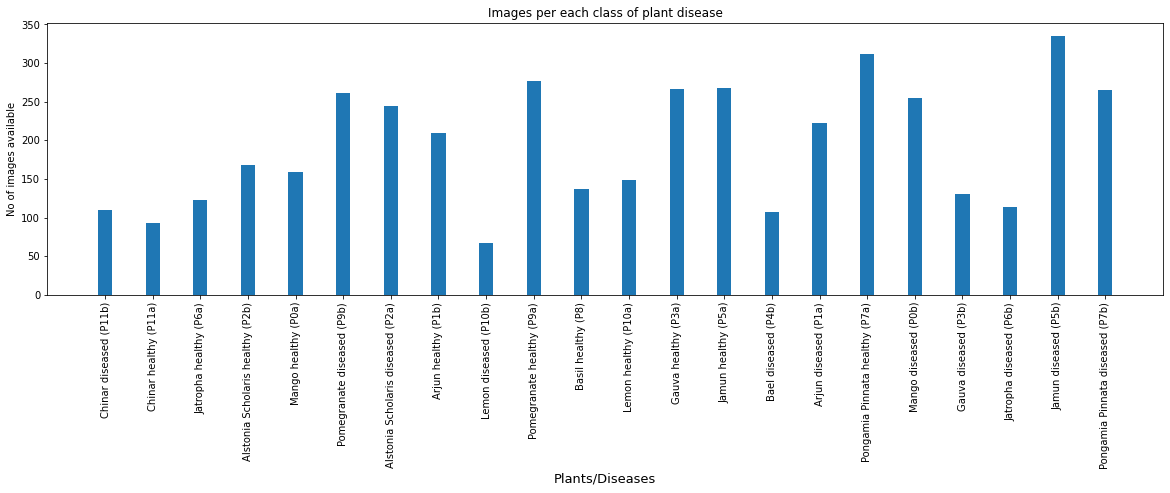

In [ ]:
# plotting number of images available for each disease
index = [n for n in range(22)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=13)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=10, rotation=90)
plt.title('Images per each class of plant disease')

In [ ]:
import torchvision
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 4274 images for training


In [ ]:
# datasets for validation and training
# train = ImageFolder(train_dir, transform=transforms.ToTensor())
# valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

# datasets for validation and training
train = ImageFolder(
    train_dir, transform=torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Resize((256,256),interpolation=torchvision.transforms.InterpolationMode.NEAREST)]
    ))
test = ImageFolder(
    test_dir, transform=torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Resize((256,256),interpolation=torchvision.transforms.InterpolationMode.NEAREST)]
    ))

In [ ]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
len(train.classes)


22

In [ ]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Alstonia Scholaris diseased (P2a)(0)


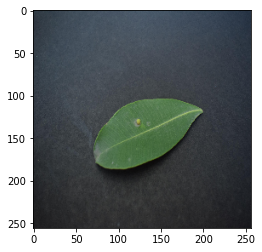

In [ ]:
show_image(*train[0])


Label :Arjun diseased (P1a)(2)


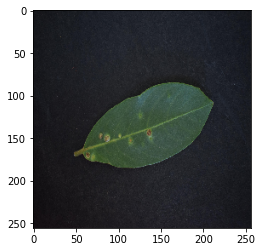

In [ ]:
show_image(*train[500])

Label :Gauva healthy (P3a)(9)


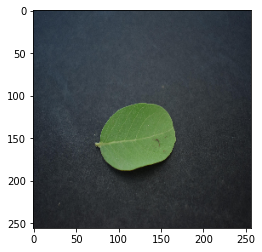

In [ ]:
show_image(*train[1500])

In [ ]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [ ]:
# setting the batch size
batch_size = 16

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size, num_workers=2, pin_memory=True)

In [ ]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

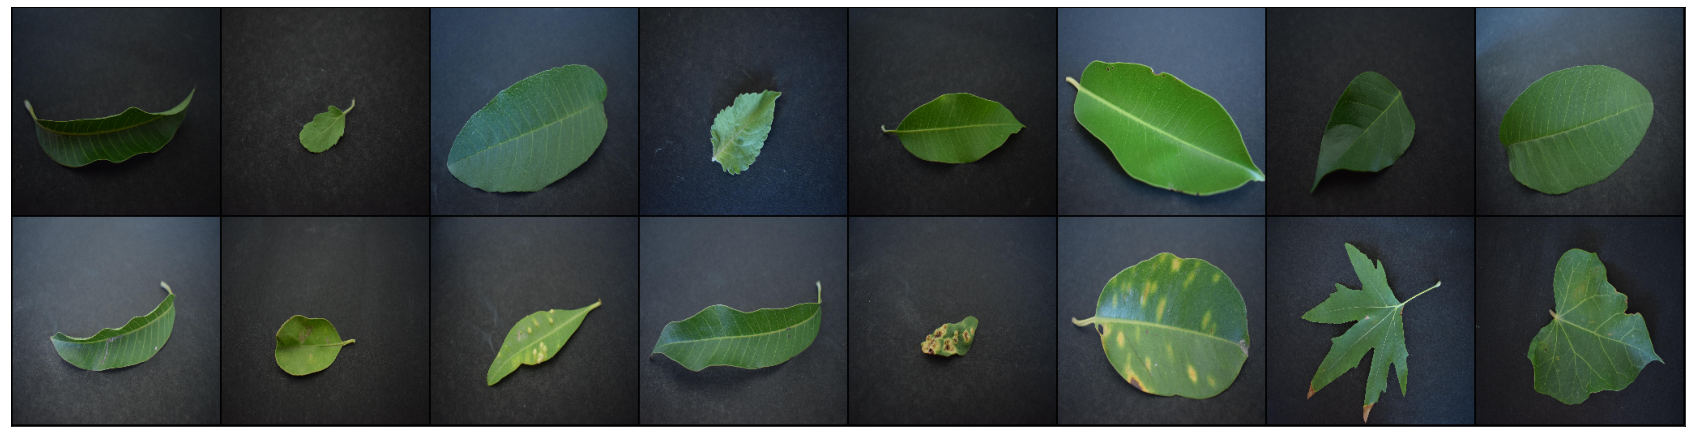

In [ ]:
# # Images for first batch of training
show_batch(train_dl) 


In [ ]:
# Modelling

In [ ]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## Building the model architecture Using ResNet

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [ ]:
# Defining the final architecture of our model

In [ ]:
#  convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [ ]:
# Training the model

In [ ]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [ ]:
%%time
history = [evaluate(model, test_dl)]
history

CPU times: user 388 ms, sys: 130 ms, total: 518 ms
Wall time: 25.8 s


[{'val_loss': tensor(3.0917, device='cuda:0'), 'val_accuracy': tensor(0.0446)}]

In [ ]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, test_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 2.6043, val_loss: 2.2517, val_acc: 0.6097
Epoch [1], last_lr: 0.00000, train_loss: 0.8088, val_loss: 0.9731, val_acc: 0.7883
CPU times: user 10.8 s, sys: 4.14 s, total: 14.9 s
Wall time: 38min 21s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

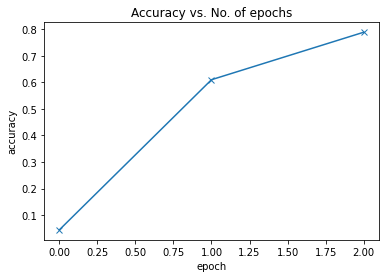

In [ ]:
# Validation Accuracy
plot_accuracies(history)


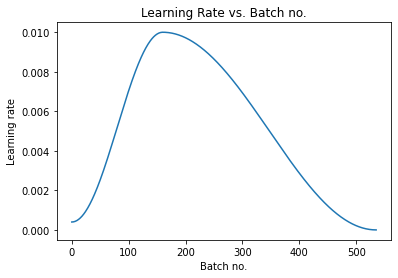

In [ ]:
# Learning Rate overtime
plot_lrs(history)

In [ ]:
# Validation Loss

val_dir = "/home/nivitus/CV_Model_Traning/Classifiers/Leaf_Classification/Plants/"
valid = ImageFolder(
    val_dir, transform=torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Resize((256,256),interpolation=torchvision.transforms.InterpolationMode.NEAREST)]
    ))

In [ ]:
valid_images = sorted(os.listdir(val_dir + '/val')) # since images in test folder are in alphabetical order
valid_images

['Alstonia Scholaris diseased (P2a)',
 'Alstonia Scholaris healthy (P2b)',
 'Arjun diseased (P1a)',
 'Arjun healthy (P1b)',
 'Bael diseased (P4b)',
 'Basil healthy (P8)',
 'Chinar diseased (P11b)',
 'Chinar healthy (P11a)',
 'Gauva diseased (P3b)',
 'Gauva healthy (P3a)',
 'Jamun diseased (P5b)',
 'Jamun healthy (P5a)',
 'Jatropha diseased (P6b)',
 'Jatropha healthy (P6a)',
 'Lemon diseased (P10b)',
 'Lemon healthy (P10a)',
 'Mango diseased (P0b)',
 'Mango healthy (P0a)',
 'Plants',
 'Pomegranate diseased (P9b)',
 'Pomegranate healthy (P9a)',
 'Pongamia Pinnata diseased (P7b)',
 'Pongamia Pinnata healthy (P7a)']

In [ ]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: Alstonia Scholaris diseased (P2a) , Predicted: Alstonia Scholaris diseased (P2a)


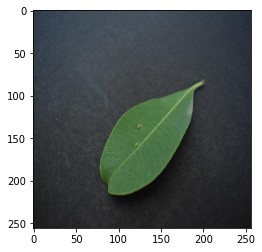

In [ ]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_images[0], ', Predicted:', predict_image(img, model))

In [ ]:
# saving to the kaggle working directory
PATH = './plant-disease-model.pth'  
torch.save(model.state_dict(), PATH)

In [ ]:
# Load the Model for inference

In [ ]:
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

## Building the model architecture Using VGG 16

In [ ]:
data_dir = "/home/nivitus/CV_Model_Traning/Classifiers/Leaf_Classification/Plants/"
train_dir = data_dir + "/train"
test_dir = data_dir + "/test"
diseases = os.listdir(train_dir)

In [ ]:
train_data = ImageFolder(
    train_dir, transform=torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Resize((256,256),interpolation=torchvision.transforms.InterpolationMode.NEAREST)]
    ))
test_data = ImageFolder(
    test_dir, transform=torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Resize((256,256),interpolation=torchvision.transforms.InterpolationMode.NEAREST)]
    ))

In [ ]:
img, label = train_data[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
len(train_data.classes)

22

In [ ]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train_data.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :Alstonia Scholaris diseased (P2a)(0)


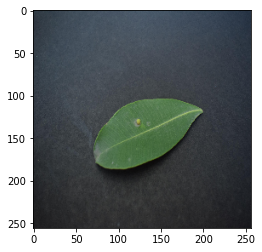

In [ ]:
show_image(*train_data[0])

Label :Alstonia Scholaris diseased (P2a)(0)


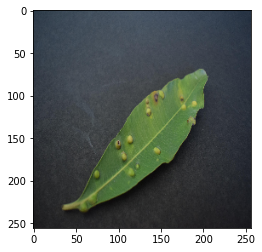

In [ ]:
show_image(*train_data[100])

Label :Basil healthy (P8)(5)


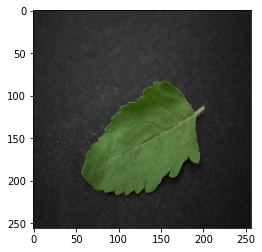

In [ ]:
show_image(*train_data[1000])

Label :Gauva healthy (P3a)(9)


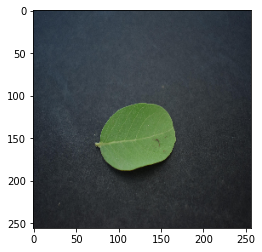

In [ ]:
show_image(*train_data[1500])

In [ ]:
# setting the batch size
batch_size_vgg = 16

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size_vgg, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size_vgg, shuffle=True, num_workers=0)

In [ ]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

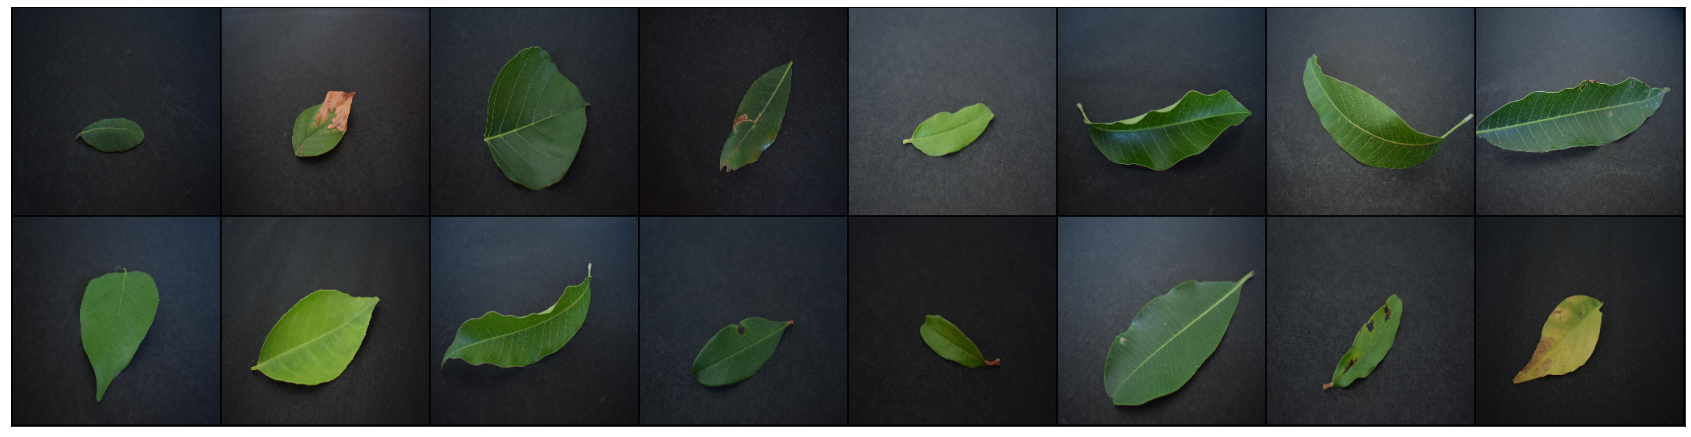

In [ ]:
# Images for first batch of training
show_batch(train_loader) 


In [ ]:
# Downloading VGG16 pretrained model and setting output features to 131 as well as shifting the model to GPU
from torchvision import models
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6].out_features = len(train_data.classes)
vgg16.to(device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freezing the convolutional layers of the model
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
# Model Training Started
optimizer = torch.optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

epoch_size = 5
for epoch in range(epoch_size):
    vgg16.train()
    tr_loss=0.0
    tr_corr=0
    
    for batch in train_loader:
        data, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        output = vgg16(data)
        loss = F.cross_entropy(output, labels)
        
        tr_loss += loss.item()
        
        _, preds = torch.max(output.data, 1)
        
        tr_corr += (preds == labels).sum().item()
        
        loss.backward()
        optimizer.step()
        
    train_loss = tr_loss/len(train_loader.dataset)
    train_accuracy = 100. * tr_corr/len(train_loader.dataset)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

Train Loss: 0.1025, Train Acc: 55.64
Train Loss: 0.0360, Train Acc: 80.51
Train Loss: 0.0237, Train Acc: 86.99
Train Loss: 0.0185, Train Acc: 89.71
Train Loss: 0.0150, Train Acc: 91.79


In [ ]:
# Evaluation block

In [ ]:
vgg16.eval()

tst_loss = 0.0
tst_corr = 0

for batch in test_loader:
    data, labels = batch[0].to(device), batch[1].to(device)
    output = vgg16(data)
    loss = F.cross_entropy(output, labels)
    
    tst_loss += loss.item()
    
    _, preds = torch.max(output.data, 1)
    
    tst_corr += (preds == labels).sum().item()
    
test_loss = tst_loss/len(test_loader.dataset)
test_accuracy = 100. * tst_corr/len(test_loader.dataset)
    
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')    

Test Loss: 0.0299, Test Acc: 84.55


In [ ]:
# Block for saving and loading the trained model state

In [ ]:
torch.save(vgg16.state_dict(), 'leaf_model_vgg16.pth')

In [ ]:
vgg16.load_state_dict(torch.load('leaf_model_vgg16.pth'))
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Random single image inference using test loader

Alstonia Scholaris healthy (P2b)


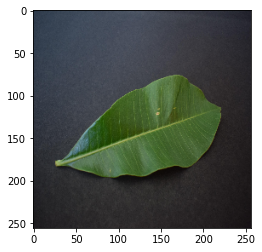

In [ ]:
from random import randrange
batch=next(iter(test_loader))
images,labels=batch
i=randrange(0,batch_size)
plt.imshow(images[i].permute(1,2,0))
print(test_data.classes[labels[i]])

In [ ]:
_,preds = torch.max(vgg16(images[i].unsqueeze(0).to(device)).data,1)
test_data.classes[preds]

'Alstonia Scholaris healthy (P2b)'

Bael diseased (P4b)


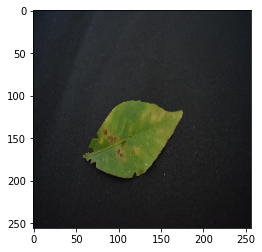

In [ ]:
batch=next(iter(test_loader))
images,labels=batch
i=randrange(0,batch_size)
plt.imshow(images[i].permute(1,2,0))
print(test_data.classes[labels[i]])

In [ ]:
_,preds = torch.max(vgg16(images[i].unsqueeze(0).to(device)).data,1)
test_data.classes[preds]

'Bael diseased (P4b)'

Lemon diseased (P10b)


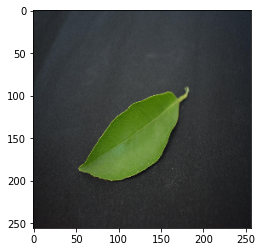

In [ ]:
batch=next(iter(test_loader))
images,labels=batch
i=randrange(0,batch_size)
plt.imshow(images[i].permute(1,2,0))
print(test_data.classes[labels[i]])

In [ ]:
_,preds = torch.max(vgg16(images[i].unsqueeze(0).to(device)).data,1)
test_data.classes[preds]

'Lemon healthy (P10a)'

Pongamia Pinnata healthy (P7a)


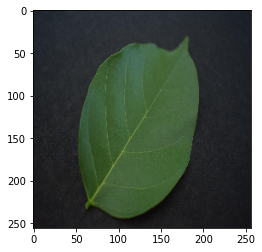

In [ ]:
batch=next(iter(test_loader))
images,labels=batch
i=randrange(0,batch_size)
plt.imshow(images[i].permute(1,2,0))
print(test_data.classes[labels[i]])

In [ ]:
_,preds = torch.max(vgg16(images[i].unsqueeze(0).to(device)).data,1)
test_data.classes[preds]

'Pongamia Pinnata healthy (P7a)'